In [1]:
!ls /kaggle/input/global-wheat-detection
!cp /kaggle/input/rcnnutils/engine.py .
!cp /kaggle/input/rcnnutils/utils.py .
!cp /kaggle/input/rcnnutils/coco_eval.py .
!cp /kaggle/input/rcnnutils/coco_utils.py .
!cp /kaggle/input/rcnnutils/transforms.py .

sample_submission.csv  test  train  train.csv


In [2]:
!mkdir -p /root/.cache/torch/checkpoints
!cp /kaggle/input/resnet50/resnet50-19c8e357.pth /root/.cache/torch/checkpoints/

In [3]:
import os
import numpy as np
import pandas as pd

import gc
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt
import utils

In [4]:
DATA_DIR = '/kaggle/input/global-wheat-detection'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
DETECTION_THRESHOLD = 0.40

In [5]:
sample_sub_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
sample_sub_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [6]:
def get_model(pre_trained=True):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pre_trained)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (wheat heads) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
%%capture
model = get_model(pre_trained=False)
model.to(DEVICE)
model.load_state_dict(torch.load(f'/kaggle/input/wheatdetectionfasterrcnn/seresnext_ls_fold0.pth', map_location=DEVICE))
model.eval()

In [8]:
class WheatDataset(Dataset):
    
    def __init__(self, image_ids, transforms):
        self.image_ids = image_ids
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index][:-4]
        image = cv2.imread(os.path.join(DATA_DIR, 'test', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        return image_id, image

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatDataset(os.listdir(os.path.join(DATA_DIR, 'test')), None)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

results = []

for image_ids, images in test_data_loader:

    images = list(image.to(DEVICE) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= DETECTION_THRESHOLD].astype(np.int32)
        scores = scores[scores >= DETECTION_THRESHOLD]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [10]:
!rm -rf *

In [11]:
sub_df = pd.DataFrame(results)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,image_id,PredictionString
0,cc3532ff6,0.9921 5 410 147 107 0.9908 375 1 84 98 0.9908...
1,796707dd7,0.9774 900 333 89 84 0.9761 508 786 85 90 0.97...
2,53f253011,0.9914 933 199 89 133 0.9888 20 591 126 151 0....
3,51f1be19e,0.9847 276 466 138 123 0.9709 499 464 207 105 ...
4,f5a1f0358,0.9838 147 758 150 112 0.9810 544 270 107 108 ...


## Plotting some of the predictions

In [12]:
def get_bboxes(pred_str):
    span=5
    preds = pred_str.split()
    bboxes = [list(map(int, preds[i+1:i+span] )) for i in range(0, len(preds), span)]
    return bboxes

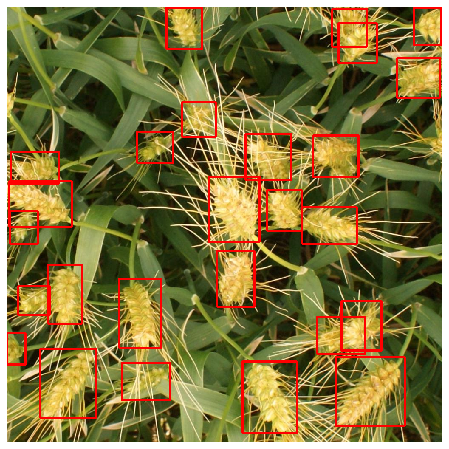

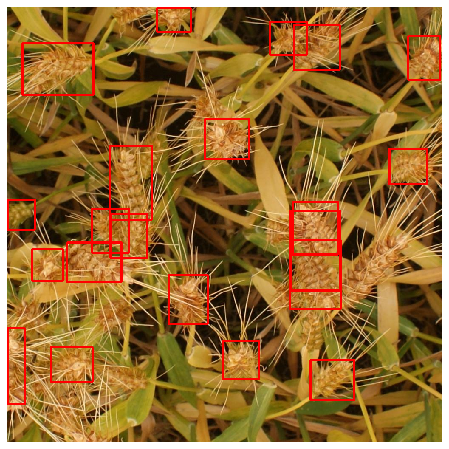

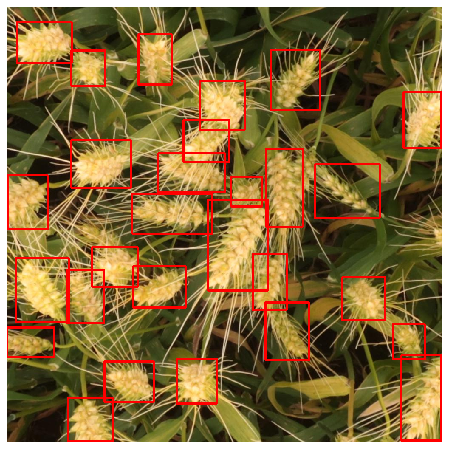

In [13]:
for image_id, pred_str in zip(sub_df.iloc[:3]['image_id'], sub_df.iloc[:3]['PredictionString']):
    image_path = os.path.join(DATA_DIR, 'test', f'{image_id}.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    boxes = get_bboxes(pred_str)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2]+box[0], box[3]+box[1]),
                      (255, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)
    plt.show()